<h2> moro </h2>


In [ ]:
# !unzip "ml-32m.zip"

Archive:  ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter

In [ ]:
# File path for the ratings CSV
file_path = "./ml-32m/ratings.csv"

ratings_df = pd.read_csv(file_path)

ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [ ]:
# Number of unique users
num_users = len(ratings_df["userId"].unique())
print(f"Number of unique users: {num_users}")

# Number of unique movies
num_movies = len(ratings_df["movieId"].unique())
print(f"Number of unique movies: {num_movies}")

# Maximum and minimum ratings
max_rating = ratings_df["rating"].max()
min_rating = ratings_df["rating"].min()
print(f"Maximum rating: {max_rating}")
print(f"Minimum rating: {min_rating}")

# Additional dataset insights
# Number of ratings
num_ratings = len(ratings_df)
print(f"Total number of ratings: {num_ratings}")

# Distribution of ratings
print("Ratings distribution:")
print(ratings_df["rating"].value_counts().sort_index())


Number of unique users: 200948
Number of unique movies: 84432
Maximum rating: 5.0
Minimum rating: 0.5
Total number of ratings: 32000204
Ratings distribution:
rating
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: count, dtype: int64


In [ ]:
# Load the ratings dataset manually
file_path = "./ml-32m/ratings.csv"
ratings_dataset = []
with open(file_path, "r") as file:
    next(file)  # Skip the header line
    for line in file:
        user_id, movie_id, rating, _ = line.strip().split(",")
        ratings_dataset.append((int(user_id), int(movie_id), float(rating)))

ratings_dataset = load_ratings(file_path)


In [ ]:
# Create mappings for user IDs and movie IDs
USER_TO_IDX = {user_id: user_idx for user_idx, user_id in enumerate(ratings_df["userId"].unique())}
MOVIE_TO_IDX = {movie_id: movie_idx for movie_idx, movie_id in enumerate(ratings_df["movieId"].unique())}

# Reverse mappings for index-to-ID conversions
idx_to_user = list(USER_TO_IDX.keys())  # List of user IDs by index
idx_to_movie = list(MOVIE_TO_IDX.keys())  # List of movie IDs by index

In [ ]:
# Calculate the total number of unique users and movies
NUM_USERS = len(idx_to_user)
NUM_MOVIES = len(idx_to_movie)

# Output the number of users and movies
NUM_USERS, NUM_MOVIES

(200948, 84432)

In [ ]:
# Initialize data structures to store user and movie data
USERS_DATA = [[] for _ in range(NUM_USERS)]  # Each user will have a list of (movieIdx, rating) tuples
MOVIES_DATA = [[] for _ in range(NUM_MOVIES)]  # Each movie will have a list of (userIdx, rating) tuples

# Populate USERS_DATA and MOVIES_DATA
for user_id, movie_id, rating in ratings_dataset:
    user_idx = USER_TO_IDX[user_id]
    movie_idx = MOVIE_TO_IDX[movie_id]
    USERS_DATA[user_idx].append((movie_idx, rating))
    MOVIES_DATA[movie_idx].append((user_idx, rating))

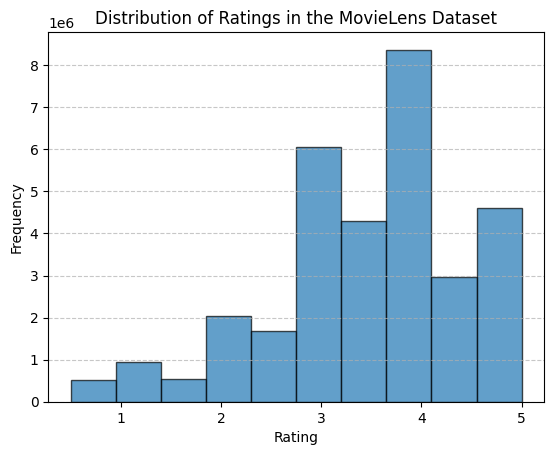

In [ ]:
# Plot the distribution of ratings
plt.hist(
    ratings_df['rating'],
    bins=10,
    edgecolor='black',
    alpha=0.7
)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings in the MovieLens Dataset")
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.show()


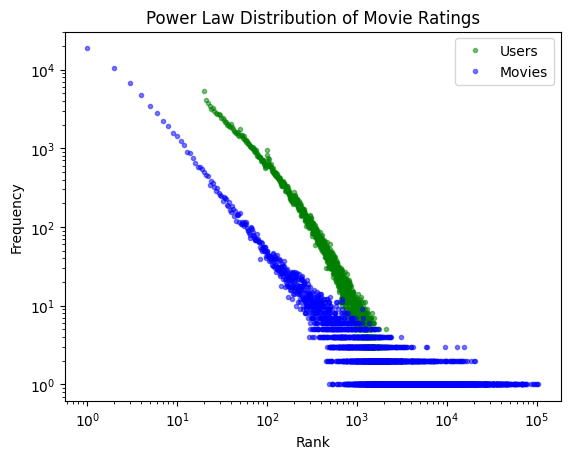

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the number of ratings per movie and per user
ratings_per_movie = [len(movie_data) for movie_data in MOVIES_DATA]
ratings_per_user = [len(user_data) for user_data in USERS_DATA]

# Count the frequency of rating counts
user_rating_frequency = Counter(ratings_per_user)
movie_rating_frequency = Counter(ratings_per_movie)

# Plot the power law distribution for users and movies
plt.loglog(
    user_rating_frequency.keys(),
    user_rating_frequency.values(),
    ".",
    color="g",
    alpha=0.2,
    label="Users"
)
plt.loglog(
    movie_rating_frequency.keys(),
    movie_rating_frequency.values(),
    ".",
    color="b",
    alpha=0.2,
    label="Movies"
)

# Add labels, title, grid, and legend
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Power Law Distribution of Movie Ratings")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()


In [ ]:
def init_empty_data(size):
    """
    Initializes a list of empty lists with a specified size.

    Parameters:
    size (int): The number of empty lists to create.

    Returns:
    list: A list of empty lists.
    """
    return [[] for _ in range(size)]

In [ ]:
def create_user_ds(user_data):
    """
    Creates user-specific datasets for watched movies and given ratings.

    Parameters:
    user_data (list): A list of user interactions with movies.

    Returns:
    tuple: Two lists - one with movie IDs watched by each user and one with their corresponding ratings.
    """
    users_watched_movies = [[] for _ in range(len(user_data))]
    users_given_ratings = [[] for _ in range(len(user_data))]

    for user_idx, user_movies in enumerate(user_data):
        users_watched_movies[user_idx] = [movie_id for movie_id, _ in user_movies]
        users_given_ratings[user_idx] = [rating for _, rating in user_movies]

    return users_watched_movies, users_given_ratings

def create_movie_ds(movie_data):
    """
    Creates movie-specific datasets for users who watched and their ratings.

    Parameters:
    movie_data (list): A list of movie interactions with users.

    Returns:
    tuple: Two lists - one with user IDs who watched each movie and one with their corresponding ratings.
    """
    movies_watched_by_users = [[] for _ in range(len(movie_data))]
    movies_received_ratings = [[] for _ in range(len(movie_data))]

    for movie_idx, movie_users in enumerate(movie_data):
        movies_watched_by_users[movie_idx] = [user_id for user_id, _ in movie_users]
        movies_received_ratings[movie_idx] = [rating for _, rating in movie_users]

    return movies_watched_by_users, movies_received_ratings

In [ ]:
def split_data(data, test_ratio):
    """
    Splits the data into training and testing sets based on a given ratio.

    Parameters:
    data (list): The data to be split.
    test_ratio (float): The proportion of data to allocate to the test set.

    Returns:
    tuple: Training and testing datasets.
    """
    train, test = init_empty_data(len(data)), init_empty_data(len(data))

    for idx, interactions in enumerate(data):
        for interaction in interactions:
            if np.random.rand() > test_ratio:
                train[idx].append(interaction)
            else:
                test[idx].append(interaction)

    return train, test


def split(users_data, movies_data, test_ratio=0.1):
    """
    Splits user and movie data into training and testing sets.

    Parameters:
    users_data (list): User interaction data.
    movies_data (list): Movie interaction data.
    test_ratio (float): Proportion of data to allocate to the test set (default is 0.1).

    Returns:
    tuple: Training and testing datasets as dictionaries.
    """
    # Split user and movie data
    users_data_train, users_data_test = split_data(users_data, test_ratio)
    movies_data_train, movies_data_test = split_data(movies_data, test_ratio)

    # Train data
    train_data = {
        "users_watched_movies": create_user_ds(users_data_train)[0],
        "users_given_ratings": create_user_ds(users_data_train)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_train)[0],
        "movies_received_ratings": create_movie_ds(movies_data_train)[1]
    }

    # Test data
    test_data = {
        "users_watched_movies": create_user_ds(users_data_test)[0],
        "users_given_ratings": create_user_ds(users_data_test)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_test)[0],
        "movies_received_ratings": create_movie_ds(movies_data_test)[1]
    }

    return train_data, test_data

In [ ]:
def init_biases(num_users, num_movies):
    """
    Initializes biases for users and movies.

    Parameters:
    num_users (int): Number of users.
    num_movies (int): Number of movies.

    Returns:
    tuple: Arrays of user biases and movie biases initialized to zero.
    """
    user_biases = np.zeros(num_users)
    movie_biases = np.zeros(num_movies)
    return user_biases, movie_biases

def init_latent_matrices(num_users, num_movies, k, seed=None):
    """
    Initializes latent matrices for users and movies.

    Parameters:
    num_users (int): Number of users.
    num_movies (int): Number of movies.
    k (int): Number of latent factors.
    seed (int, optional): Random seed for reproducibility. Default is None.

    Returns:
    tuple: User latent matrix and movie latent matrix.
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize latent matrices with random values scaled by 1/sqrt(k)
    user_latents = np.random.normal(size=(num_users, k), scale=1 / np.sqrt(k))
    movie_latents = np.random.normal(size=(num_movies, k), scale=1 / np.sqrt(k))

    return user_latents, movie_latents


In [ ]:
def update_users_biases(users_movies_data, users_ratings_data, movie_biases, lambda_, gamma):
    """
    Updates user biases based on observed ratings and movie biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    movie_biases (ndarray): Array of movie biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates user_biases in place.
    """
    for i in range(len(users_movies_data)):
        user_movies = users_movies_data[i]  # Movies rated by the user
        user_ratings = users_ratings_data[i]  # Ratings given by the user
        num_movies = len(user_movies)  # Number of movies rated by the user
        if num_movies > 0:
            user_biases[i] = lambda_ * np.sum(user_ratings - movie_biases[user_movies]) / (lambda_ * num_movies + gamma)


In [ ]:
def update_movies_biases(movies_users_data, movies_ratings_data, user_biases, lambda_, gamma):
    """
    Updates movie biases based on observed ratings and user biases.

    Parameters:
    movies_users_data (list): List of users who rated each movie.
    movies_ratings_data (list): List of ratings received by each movie.
    user_biases (ndarray): Array of user biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates movie_biases in place.
    """
    for i in range(len(movies_users_data)):
        movie_users = movies_users_data[i]  # Users who rated the movie
        movie_ratings = movies_ratings_data[i]  # Ratings given to the movie
        num_users = len(movie_users)  # Number of users who rated the movie
        if num_users > 0:
            movie_biases[i] = lambda_ * np.sum(movie_ratings - user_biases[movie_users]) / (lambda_ * num_users + gamma)


In [ ]:
def update_user_latents(users_movies_data, users_ratings_data, user_biases, movie_biases, U, V, lambda_, tau, k):
    """
    Updates user latent factor matrices.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter.
    tau (float): Weight parameter for the identity matrix.
    k (int): Number of latent factors.

    Returns:
    None: Updates U in place.
    """
    for i in range(len(users_movies_data)):
        user_movies = users_movies_data[i]  # Movies rated by user i
        user_ratings = users_ratings_data[i]  # Ratings given by user i

        # Regularization term
        inv_term = lambda_ * np.dot(V[user_movies].T, V[user_movies]) + tau * np.eye(k)

        # Term involving ratings and biases
        term = lambda_ * np.dot(
            V[user_movies].T,
            user_ratings - movie_biases[user_movies] - user_biases[i]
        )

        # Update user latent factors
        U[i] = np.dot(np.linalg.inv(inv_term), term)

In [ ]:
def update_movie_latents(movies_users_data, movies_ratings_data, user_biases, movie_biases, U, V, lambda_, tau, k):
    """
    Updates movie latent factor matrices.

    Parameters:
    movies_users_data (list): List of users who rated each movie.
    movies_ratings_data (list): List of ratings received by each movie.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter.
    tau (float): Weight parameter for the identity matrix.
    k (int): Number of latent factors.

    Returns:
    None: Updates V in place.
    """
    for i in range(len(movies_users_data)):
        movie_users = movies_users_data[i]  # Users who rated movie i
        movie_ratings = movies_ratings_data[i]  # Ratings given to movie i

        # Regularization term
        inv_term = lambda_ * np.dot(U[movie_users].T, U[movie_users]) + tau * np.eye(k)

        # Term involving ratings and biases
        term = lambda_ * np.dot(
            U[movie_users].T,
            movie_ratings - user_biases[movie_users] - movie_biases[i]
        )

        # Update movie latent factors
        V[i] = np.dot(np.linalg.inv(inv_term), term)

In [ ]:
def calc_loss(users_movies_data, users_ratings_data, user_biases, movie_biases, U, V, lambda_, gamma, tau):
    """
    Calculates the RMSE and total loss for the current state of latent factors and biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    U (ndarray): User latent matrix.
    V (ndarray): Movie latent matrix.
    lambda_ (float): Regularization parameter for error term.
    gamma (float): Regularization parameter for biases.
    tau (float): Regularization parameter for latent matrices.

    Returns:
    tuple: RMSE (float) and total loss (float).
    """
    total_error = 0.0
    num_ratings = 0

    # Calculate total error and number of ratings
    for i in range(len(users_movies_data)):
        user_ratings = np.array(users_ratings_data[i], dtype=np.float32)
        user_movies = np.array(users_movies_data[i], dtype=np.int32)
        num_ratings += len(user_movies)

        # Predicted ratings
        preds = np.dot(V[user_movies], U[i]) + user_biases[i] + movie_biases[user_movies]

        # Accumulate squared error
        total_error += np.sum((user_ratings - preds) ** 2)

    # Compute RMSE
    rmse = np.sqrt(total_error / num_ratings)

    # Compute total loss with regularization
    loss = (
        (lambda_ / 2) * total_error
        + (tau / 2) * (np.sum(U ** 2) + np.sum(V ** 2))
        + (gamma / 2) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
    )

    return rmse, loss


In [ ]:

# Split the data into training and testing sets
train_data, test_data = split(USERS_DATA, MOVIES_DATA)

# Training data - users
users_watched_movies_train = train_data["users_watched_movies"]  # Movies watched by each user in training set
users_given_ratings_train = train_data["users_given_ratings"]  # Ratings given by each user in training set

# Testing data - users
users_watched_movies_test = test_data["users_watched_movies"]  # Movies watched by each user in testing set
users_given_ratings_test = test_data["users_given_ratings"]  # Ratings given by each user in testing set

# Training data - movies
movies_watched_by_users_train = train_data["movies_watched_by_users"]  # Users who watched each movie in training set
movies_received_ratings_train = train_data["movies_received_ratings"]  # Ratings received by each movie in training set

# Testing data - movies
movies_watched_by_users_test = test_data["movies_watched_by_users"]  # Users who watched each movie in testing set
movies_received_ratings_test = test_data["movies_received_ratings"]  # Ratings received by each movie in testing set

In [ ]:
# Initialize biases for users and movies and latents
user_biases, movie_biases = init_biases(NUM_USERS, NUM_MOVIES)
U_matrix, V_matrix = init_latent_matrices(NUM_USERS, NUM_MOVIES, k, seed=101)
# Initialize hyperparameters
lambda_ = 0.1
gamma = 0.01
tau = 0.1
k = 16

In [ ]:
rmse_train_losses = []
rmse_test_losses = []
losses = []

# Run for 10 iterations (epochs)
for i in range(10):
    start_time = time.time()  # Start time for the epoch

    # Update user biases and latent factors
    update_users_biases(
        users_watched_movies_train,
        users_given_ratings_train,
        movie_biases,
        U_matrix,
        V_matrix,
        lambda_,
        gamma
    )
    update_user_latents(
        users_watched_movies_train,
        users_given_ratings_train,
        user_biases,
        movie_biases,
        U_matrix,
        V_matrix,
        lambda_,
        tau,
        k
    )

    # Update movie biases and latent factors
    update_movies_biases(
        movies_watched_by_users_train,
        movies_received_ratings_train,
        user_biases,
        U_matrix,
        V_matrix,
        lambda_,
        gamma
    )
    update_movie_latents(
        movies_watched_by_users_train,
        movies_received_ratings_train,
        user_biases,
        movie_biases,
        U_matrix,
        V_matrix,
        lambda_,
        tau,
        k
    )

    # Calculate training losses
    rmse_train, loss_train = calc_loss(
        users_watched_movies_train,
        users_given_ratings_train,
        user_biases,
        movie_biases,
        U_matrix,
        V_matrix,
        lambda_,
        gamma,
        tau
    )

    # Calculate testing RMSE
    rmse_test, _ = calc_loss(
        users_watched_movies_test,
        users_given_ratings_test,
        user_biases,
        movie_biases,
        U_matrix,
        V_matrix,
        lambda_,
        gamma,
        tau
    )

    # Append losses to their respective lists
    rmse_train_losses.append(rmse_train)
    rmse_test_losses.append(rmse_test)
    losses.append(loss_train)

    end_time = time.time()  # End time for the epoch

    # Print results for the current iteration
    print(
        f"Iteration: {i + 1}\t"
        f"Train Loss: {loss_train:.4f}\t"
        f"RMSE Train: {rmse_train:.4f}\t"
        f"RMSE Test: {rmse_test:.4f}"
    )
    print(f"Epoch time: {end_time - start_time:.2f} seconds\n")

Iteration: 1	Train Loss: 975605.9976	RMSE train: 0.8067347333689889	RMSE test: 0.8858894929609772

Epoch time: 68.42

Iteration: 2	Train Loss: 832285.8227	RMSE train: 0.7416925257004119	RMSE test: 0.8268795052827406

Epoch time: 64.17

Iteration: 3	Train Loss: 766026.0700	RMSE train: 0.7097711835188192	RMSE test: 0.7961175799790307

Epoch time: 66.10

Iteration: 4	Train Loss: 733862.9687	RMSE train: 0.6939088658218105	RMSE test: 0.780879471065949

Epoch time: 66.70

Iteration: 5	Train Loss: 716755.0479	RMSE train: 0.6854778824236403	RMSE test: 0.772964066154805

Epoch time: 68.05

Iteration: 6	Train Loss: 706456.5742	RMSE train: 0.6804643989323469	RMSE test: 0.7684557651050169

Epoch time: 71.40

Iteration: 7	Train Loss: 699662.5541	RMSE train: 0.6772152318975974	RMSE test: 0.7657099098595292

Epoch time: 73.50

Iteration: 8	Train Loss: 694919.6530	RMSE train: 0.6749968834036463	RMSE test: 0.7639606639095279

Epoch time: 68.26

Iteration: 9	Train Loss: 691463.8147	RMSE train: 0.6734204

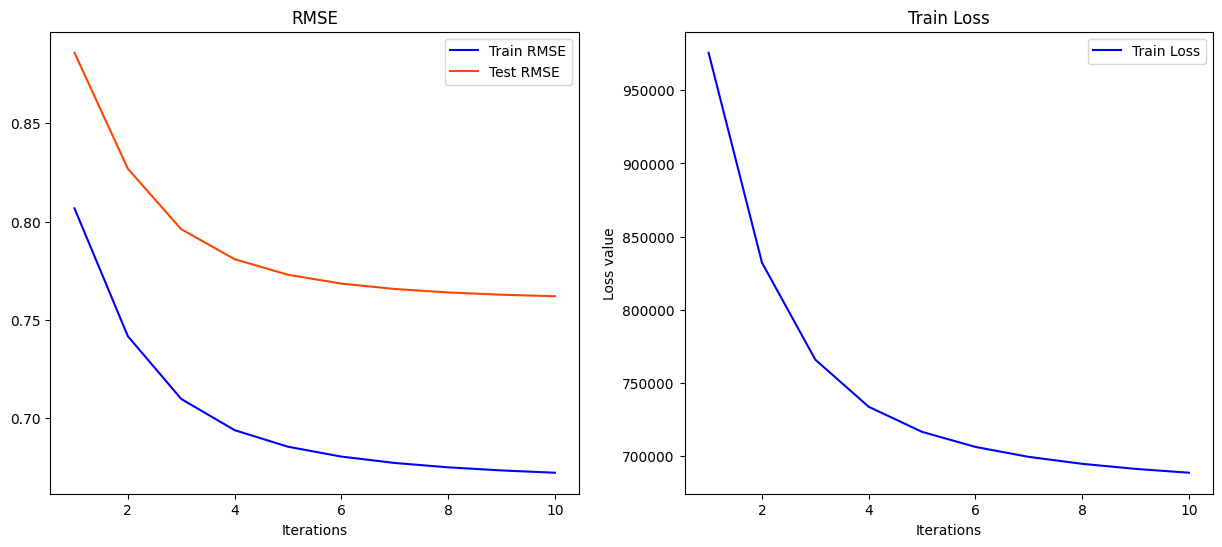

In [ ]:
iterations = np.arange(1, 11)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot RMSE for training and testing
ax[0].plot(iterations, rmse_train_losses, label="Train RMSE", color="b")
ax[0].plot(iterations, rmse_test_losses, label="Test RMSE", color="orangered")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("RMSE Value")
ax[0].set_title("RMSE")
ax[0].legend()

# Plot training loss
ax[1].plot(iterations, losses, label="Train Loss", color="b")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Loss Value")
ax[1].set_title("Train Loss")
ax[1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Load the movies dataset
all_movies = pd.read_csv('./ml-25m/movies.csv')

all_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
def retrieve_title_id(search):
    """
    Retrieves movie titles and IDs that match the search query.

    Parameters:
    search (str): The search query to look for in movie titles.

    Returns:
    list: A list of tuples containing movie IDs and titles that match the search.
    """
    results = []
    for movie_id, movie_title in zip(all_movies["movieId"], all_movies["title"]):
        if search.lower() in movie_title.lower():
            results.append((movie_id, movie_title))
    return results


# Combine each movie title with its respective ID
movies_dictionary = dict(zip(all_movies['movieId'], all_movies['title']))
# Example
retrieve_title_id("lord of the rings")


[(2116, 'Lord of the Rings, The (1978)'),
 (4993, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (5952, 'Lord of the Rings: The Two Towers, The (2002)'),
 (7153, 'Lord of the Rings: The Return of the King, The (2003)')]

In [ ]:
def update_dummy_user(dummy_user_data, V_matrix, MOVIE_TO_IDX, k=2, lambda_=0.01, gamma=0.1, tau=0.1, iterations=10):
    """
    Updates the dummy user's bias and latent vector.

    Parameters:
    - dummy_user_data: list of tuples [(movie_id, rating)]
    - V_matrix: Movie latent matrix
    - MOVIE_TO_IDX: Mapping of movie IDs to indices
    - k: Number of latent factors
    - lambda_, gamma, tau: Regularization and update hyperparameters
    - iterations: Number of update iterations

    Returns:
    - dummy_user_bias: Final bias for the dummy user
    - dummy_user_latent: Final latent vector for the dummy user
    """
    dummy_user_bias = 0.0
    dummy_user_latent = np.zeros(k)

    for i in tqdm(range(iterations), desc="Updating Dummy User"):
        bias_sum = 0
        term1 = np.zeros((k, k))
        term2 = np.zeros(k)
        num_movies = len(dummy_user_data)

        for movie_id, rating in dummy_user_data:
            movie_idx = MOVIE_TO_IDX[movie_id]
            residual = rating - (np.dot(dummy_user_latent, V_matrix[movie_idx]) + movie_biases[movie_idx])
            bias_sum += residual
            term2 += V_matrix[movie_idx] * residual
            term1 += np.outer(V_matrix[movie_idx], V_matrix[movie_idx])

        # Update dummy user bias
        dummy_user_bias = (lambda_ * bias_sum) / ((lambda_ * num_movies) + gamma)

        # Update dummy user latent vector
        term1 = lambda_ * term1 + tau * np.identity(k)
        term2 *= lambda_
        dummy_user_latent = np.linalg.solve(term1, term2)

    return dummy_user_bias, dummy_user_latent


In [ ]:
def generate_recommendations(dummy_user_latent, V_matrix, movie_biases, top_n=10):
    """
    Generates top-N movie recommendations for the dummy user.

    Parameters:
    - dummy_user_latent: Latent vector for the dummy user
    - V_matrix: Movie latent matrix
    - movie_biases: Biases for all movies
    - top_n: Number of top recommendations to return

    Returns:
    - recommendations: List of tuples [(predicted_rating, movie_id)]
    """
    recommendations = []

    for movie_idx, movie_latent in enumerate(V_matrix):
        predicted_rating = 0.05 * movie_biases[movie_idx] + np.dot(dummy_user_latent, movie_latent)
        recommendations.append((predicted_rating, movie_idx))

    # Sort by predicted rating in descending order
    recommendations.sort(reverse=True, key=lambda x: x[0])

    return recommendations[:top_n]


In [ ]:
def display_recommendations(recommendations, MOVIE_TO_IDX, movies_dictionary):
    """
    Displays the top recommendations in a readable format.

    Parameters:
    - recommendations: List of tuples [(predicted_rating, movie_idx)]
    - MOVIE_TO_IDX: Mapping of movie IDs to indices
    - movies_dictionary: Mapping of movie IDs to titles
    """
    print("Top Recommendations:")
    for predicted_rating, movie_idx in recommendations:
        for movie_id, idx in MOVIE_TO_IDX.items():
            if idx == movie_idx:
                print(f"Movie: {movies_dictionary[movie_id]}")
                break


In [ ]:
dummy_user_bias, dummy_user_latent = update_dummy_user([(1,5.0)], V_matrix, MOVIE_TO_IDX, k=16, lambda_=0.1, gamma=0.01, tau=0.1, iterations=10)
recommendations = generate_recommendations(dummy_user_latent, V_matrix, movie_biases, top_n=10)
display_recommendations(recommendations, MOVIE_TO_IDX, movies_dictionary)

Updating Dummy User: 100%|████████████████████| 10/10 [00:00<00:00, 9955.62it/s]

Top Recommendations:
Movie: Toy Story 2 (1999)
Movie: Toy Story 3 (2010)
Movie: Toy Story (1995)
Movie: Beauty and the Beast (1991)
Movie: Finding Nemo (2003)
Movie: Monsters, Inc. (2001)
Movie: Incredibles, The (2004)
Movie: Aladdin (1992)
Movie: Pluto's Christmas Tree (1952)
Movie: Bug's Life, A (1998)


In [ ]:
dummy_user_bias, dummy_user_latent = update_dummy_user([(1,5.0)], V_matrix, MOVIE_TO_IDX, k=16, lambda_=0.1, gamma=0.01, tau=0.1, iterations=10)
recommendations = generate_recommendations(dummy_user_latent, V_matrix, movie_biases, top_n=10)
display_recommendations(recommendations, MOVIE_TO_IDX, movies_dictionary)

NameError: name 'update_dummy_user' is not defined

In [ ]:
learned_weights = {"U":U_matrix, "V":V_matrix, "user_biases":user_biases, "movie_biases":movie_biases}
np.savez_compressed("model_latents_biases.npz",**learned_weights)
print("saved succesfully")

saved succesfully


In [ ]:
model_weights = np.load("model_weights.npz")
model_weights["movie_biases"]

array([ 0.20682743,  0.08223645,  0.20264096, ...,  0.42875391,
        0.83492956, -0.82822894])

Enter the MovieLens IDs you want to highlight (comma-separated): 63436, 1721, 2153, 164909, 2116, 1


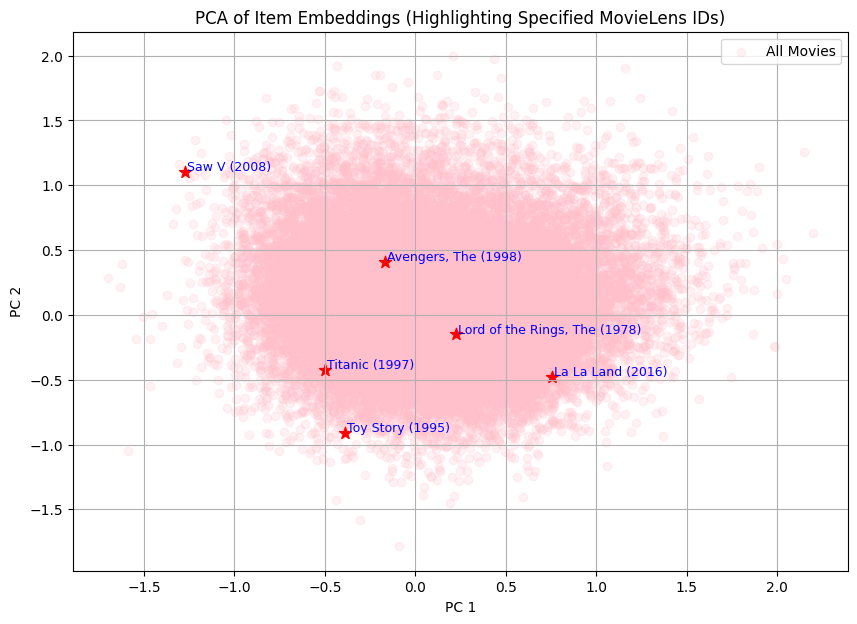

In [ ]:
from sklearn.decomposition import PCA

item_to_index = MOVIE_TO_IDX
movie_titles = [None] * NUM_MOVIES
for row in all_movies.itertuples():
    if row.movieId in item_to_index:
        idx = item_to_index[row.movieId]
        movie_titles[idx] = row.title

def plot_item_embeddings_with_ids(item_latent, movie_titles, movie_ids_list):
    """
    Reduce item_latent to 2D with PCA, then plot the entire set of embeddings.
    Highlight any movies that match a user-provided list of MovieLens IDs.
    """
    pca = PCA(n_components=2)
    item_latent_2d = pca.fit_transform(item_latent)

    plt.figure(figsize=(10, 7))
    plt.scatter(item_latent_2d[:, 0], item_latent_2d[:, 1],
                alpha=0.2, label="All Movies", color='pink')

    for mid in movie_ids_list:
        if mid in item_to_index:
            idx = item_to_index[mid]
            x_val = item_latent_2d[idx, 0]
            y_val = item_latent_2d[idx, 1]
            # Draw a red 'x' for the point
            plt.scatter(x_val, y_val, color='red', s=80, marker='*')
            # Label the point with the movie title
            plt.text(x_val + 0.01, y_val + 0.01,
                     movie_titles[idx] or f"ID {mid}",
                     fontsize=9, color='blue')

    plt.title("PCA of Item Embeddings (Highlighting Specified MovieLens IDs)")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend()
    plt.grid(True)
    plt.savefig("PCA_EMBEDDING_SPACE.svg")
    plt.show()


movie_ids_input_str = input("Enter the MovieLens IDs you want to highlight (comma-separated): ")
movie_ids_input = [int(x.strip()) for x in movie_ids_input_str.split(',')]


plot_item_embeddings_with_ids(model_weights["V"], movie_titles, movie_ids_input)


In [ ]:
# 63436, 1721, 2153, 164909, 2116